## Multiple Schemas

Normally, all graph nodes communicate with a single schema.

Also, this single schema contains the graph's input and output keys / channels.

- Internal nodes may pass information that is not required in the graph's input / output.

- We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

## 1. Private State

- This can encapsulate the internal state not going to the input output in the graph that are not relevant to the input and output.


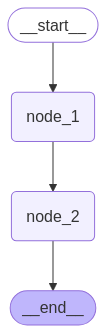

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

# make node to get the state overall state as input and update the internal state
# this return the internal state 
def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    print(state)
    # node should update the state 
    return {"baz": state['foo'] + 1}

# make node to get the state internal state as input and update the overall state
# this return the overall state
def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    print(state)
    return {"foo": state['baz'] + 1}

# build the graph
# build it using input state 
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# add the edges 
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# compile the graph
graph = builder.compile()

# view the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# invoke the graph using initial state
# in each node it print its incoming state
# for invoke the state graph we should pass the initial state
graph.invoke({"foo" : 1})

---Node 1---
{'foo': 1}
---Node 2---
{'baz': 2}


{'foo': 3}

## 2. Input output schemas

- Here, input / output schemas perform filtering on what keys are permitted on the input and output of the graph.

- In addition, we can use a type hint state: InputState to specify the input schema of each of our nodes.

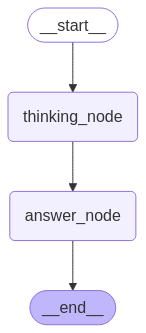

In [4]:
# define schemas for input and output
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

# this is schema for internal state
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState) -> OverallState:
    # this is first node this input the input schema and update the 
    # overall state is updated by this node
    # node is updating his state
    print(state)
    return {"answer": "bye", "notes": "his name is Hansidu."}

def answer_node(state: OverallState) -> OutputState:
    print(state)
    return {"answer": "Bye Hansidu"}

# make the graph with input and output schemas
# schemas should provide at the when the state graph object creation 
graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

# compile the graph 
graph = graph.compile()

# view the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"question":"hi I am Hansidu"})

{'question': 'hi I am Hansidu'}
{'question': 'hi I am Hansidu', 'answer': 'bye', 'notes': 'his name is Hansidu.'}


{'answer': 'Bye Hansidu'}

## 3. State reducers

They specify how to perform updates.

We can use the Annotated type to specify a reducer function.

We just need a reducer that can perform this: operator.add is a function from Python's built-in operator module.

When operator.add is applied to lists, it performs list concatenation.

- operator.add function perform the list concatenation 

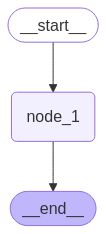

In [6]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

## 4. Custom Reducers

Lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be None.

In [8]:
def reduce_list(left: list | None, right: list | None) -> list:
    # safely combine two list whether the left or right list is none
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# state class with add operation
class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

# state class with custom reducer
class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

#### Below although it use initial state of none it works with custom reducer function

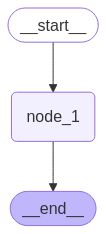

---Node 1---
{'foo': [2]}


In [9]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## 5. Filtering and trimming messages

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

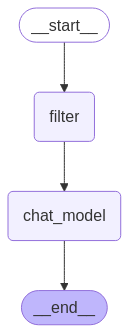

In [12]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState
from langchain_core.messages import RemoveMessage

# make a function that invoke the llm with given messages
def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# make node to trim the messages
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

# create the graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# view the graph as image
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# invoke the graph using above messages
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Whales are a good start. To broaden your knowledge of ocean mammals, here's a breakdown of other important groups and some specific examples you might find interesting:

**1. Pinnipeds (Seals, Sea Lions, and Walruses):**

*   **General Characteristics:** These are semi-aquatic mammals with flippers for swimming and movement on land. They are generally carnivorous, feeding on fish, squid, and crustaceans.
*   **Seals (True Seals or Earless Seals):**
    *   **Key Features:** Lack external ear flaps, have shorter flippers, and move on land by wriggling their bodies.
    *   **Examples:** Harbor Seal, G

### Filtering the messages

- Only pass the last message to the llm not the whole list of messages.

- Just pass in a filtered list: llm.invoke(messages[-1:]) to the model.

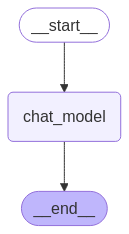

In [14]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# make the graph using the filtered message node
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# view the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [16]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Whales are a good start. To broaden your knowledge of ocean mammals, here's a breakdown of other important groups and some specific examples you might find interesting:

**1. Pinnipeds (Seals, Sea Lions, and Walruses):**

*   **General Characteristics:** These are semi-aquatic mammals with flippers for swimming and movement on land. They are generally carnivorous, feeding on fish, squid, and crustaceans.
*   *

### Trimming messages

Another approach is to trim messages, based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.


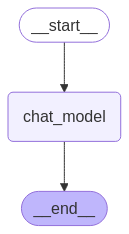

In [12]:
# define a chat node with only input specific amount of tokens passed to the llm
from langchain_core.messages import trim_messages

def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## 6.Chatbot with message summarization

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

In [3]:
# make the state to store the summery of the conversation
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

In [4]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# function to call the model
def call_model(state: State):
    # get the message summery if there
    summary = state.get("summary","")

    # if summery exist
    if summary:
        # get the new messages and get the summary 
        # then add the new messages and invoke the llm
        # add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # append system message and the current messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    # then invoke the llm
    response = llm.invoke(messages)
    
    # return the state of the node
    return {"messages": response}

In [6]:
# function to summarize the messages
def summarize_conversation(state: State):
    # first get the summery if there
    summary = state.get("summary", "")

    # if there is an already summery then add to the
    # same summery
    if summary:
        # make system message
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # invoke the model to generate a summary
    response = llm.invoke(messages)
    
    # show the model summary
    print(response)

    # remove unwanted messages from the 
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    # return the current state
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [7]:
from langgraph.graph import END
# decide whether continue or make a summery 
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # if there are more than six messages
    # then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # otherwise we can just end
    return END

In [14]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# make the graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# set the end point of the conversation 
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# compile the graph with the memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

## 7. Threads
The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a thread of conversation.

with the help of thread id we can get the specific conversation.

In [19]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# start the conversation 
input_message = HumanMessage(content="hi! I'm Janith Hansidu")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I am 24 years old.")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what is my age?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Janith Hansidu! It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Janith Hansidu. You just told me! 😊
================================== Ai Message ==================================

Okay, good to know! So, you're Janith Hansidu, and you're 24 years old. Is there anything else you'd like to tell me, or anything I can help you with?
content='The conversation started with Janith Hansidu introducing themselves. I acknowledged them and asked how I could help. Janith then asked what their name was, which I reiterated. They then stated they were 24 years old. I acknowledged this and asked if there was anything else they wanted to share or needed help with. Finally, they asked what their age was, which I again reiterated based on their previous statement.' additional_kwargs={} response_metadata={'prompt_feedback': {

In [20]:
input_message = HumanMessage(content="what is my age?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

As you mentioned earlier, you are 24 years old.
